# Evaluación de diversidad transcriptómica intra-clonal 
## *Sheila Santomé*

En esta libreta se describe la **pipeline utilizada para analizar la diversidad intraclonal** de las muestras.  

Se distinguen **dos secciones principales**:  
1. Una sección destinada al **análisis de una sola muestra**, permitiendo estudiar la heterogeneidad intraclonal de manera individual.  
2. Una sección en la que se analizan de forma conjunta las muestras de **ratón_1**, **ratón_3** y los **dos pools**, facilitando comparaciones y análisis integrados entre diferentes muestras.


-----------------------------

In [ ]:
from collections import Counter
from scipy.spatial import ConvexHull
from scipy.stats import entropy, mannwhitneyu, spearmanr, wilcoxon
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import scanpy as sc
import seaborn as sns


## Funciones para el cálculo de métricas intraclonales

Para cada clon (cada **barcode**) se seleccionan las células correspondientes dentro de cada condición, realizando un **clustering interno con Leiden** para detectar subpoblaciones. A partir de este clustering se calculan métricas de diversidad como el **número de clusters**, la **entropía de Shannon y Simpson** y el **índice de Pielou**, que reflejan la heterogeneidad y el equilibrio de las subpoblaciones dentro del clon. También se mide la **dispersión de las células en embeddings** (PCA o UMAP) para evaluar cómo se distribuyen en el espacio latente.

Además, se incluyen **estimaciones adicionales de robustez**: el **bootstrap de entropía** proporciona intervalos de confianza para la diversidad, mientras que el **submuestreo** permite calcular la entropía en subconjuntos de células, equilibrando clones de distinto tamaño. En conjunto, estas métricas permiten cuantificar la **diversidad intraclonal**, identificar subpoblaciones celulares y estudiar la distribución de células tanto en clusters internos como en el espacio global.


In [ ]:
# ---- Funciones auxiliares ----
def shannon(proportions):
    ps = np.array(proportions, dtype=float)
    ps = ps[ps > 0]
    return entropy(ps, base=np.e)

def simpson_index(proportions):
    ps = np.array(proportions, dtype=float)
    return 1.0 - np.sum(ps**2)

def pielou_evenness(proportions):
    ps = np.array(proportions, dtype=float)
    ps = ps[ps > 0]
    if len(ps) == 0:
        return np.nan
    H = entropy(ps, base=np.e)
    Hmax = np.log(len(proportions)) if len(proportions) > 0 else np.nan
    return H / Hmax if Hmax > 0 else np.nan

def bootstrap_entropy(counts, n_resamples=200):
    """IC bootstrap (percentil 2.5–97.5) de entropía de Shannon"""
    counts_arr = np.array(list(counts.values()), dtype=int)
    n = counts_arr.sum()
    probs = counts_arr / n
    vals = []
    for _ in range(n_resamples):
        sim = np.random.multinomial(n, probs)
        p = sim / sim.sum() if sim.sum() > 0 else np.zeros_like(sim)
        vals.append(entropy(p, base=np.e))
    return np.percentile(vals, [2.5, 97.5])

def subsample_entropy(counts, subsample_size=50, n_reps=50):
    """Submuestreo sin reemplazo (rarefaction) para entropía"""
    labels = []
    for i, c in enumerate(counts.values()):
        labels.extend([i] * int(c))
    labels = np.array(labels)
    if subsample_size > len(labels):
        return np.nan, np.nan
    vals = []
    for _ in range(n_reps):
        pick = np.random.choice(labels, subsample_size, replace=False)
        csub = np.bincount(pick, minlength=len(counts))
        p = csub / csub.sum()
        vals.append(entropy(p, base=np.e))
    return np.median(vals), np.std(vals)
def dispersion_metrics(embedding):
    """
    Calcula métricas de dispersión de un conjunto de puntos (células) en un embedding.
    Devuelve un diccionario con al menos 'dispersion_umap'.
    """
    if embedding is None or len(embedding) == 0:
        return {'dispersion_umap': np.nan}

    # Centroid
    centroid = np.mean(embedding, axis=0)
    
    # Distancia media al centroide
    dists = np.linalg.norm(embedding - centroid, axis=1)
    dispersion = np.mean(dists)
    
    return {'dispersion_umap': dispersion}

# ---- Función principal modificada ----
def analyze_clone_in_condition(
    adata, clone_col='barcode', clone_id=None, condition=None,
    cluster_resolution=0.5, use_embedding='X_pca',
    subsample_size=50, n_bootstrap=200
):
    """Devuelve métricas para un clon en una condición concreta,
       incluyendo Pielou, bootstrap e incluso entropía por submuestreo."""
    mask = (adata.obs[clone_col] == clone_id) & (adata.obs['condition'] == condition)
    sub = adata[mask].copy()
    n_cells = sub.n_obs
    out = {'clone': clone_id, 'condition': condition, 'n_cells': n_cells}

    if n_cells == 0:
        return out

    # --- Clustering dentro del subset ---
    try:
        sc.pp.pca(sub, n_comps=min(20, sub.shape[1]), svd_solver='arpack')
    except Exception:
        pass
    sc.pp.neighbors(sub, n_neighbors=min(10, max(2, n_cells - 1)),
                    n_pcs=min(20, sub.obsm['X_pca'].shape[1]))
    sc.tl.leiden(sub, resolution=cluster_resolution, key_added='leiden_sub')

    # --- Métricas de diversidad de clusters ---
    cluster_counts = Counter(sub.obs['leiden_sub'])
    out['n_clusters'] = len(cluster_counts)

    props = np.array(list(cluster_counts.values()), dtype=float) / n_cells
    out['shannon_clusters'] = shannon(props)
    out['simpson_clusters'] = simpson_index(props)
    out['pielou_clusters'] = pielou_evenness(props)

    # Bootstrap IC95 para entropía
    if len(cluster_counts) > 1:
        ci_low, ci_high = bootstrap_entropy(cluster_counts, n_resamples=n_bootstrap)
        out['shannon_bootstrap_ci_low'] = ci_low
        out['shannon_bootstrap_ci_high'] = ci_high
    else:
        out['shannon_bootstrap_ci_low'] = np.nan
        out['shannon_bootstrap_ci_high'] = np.nan

    # Submuestreo si hay células suficientes
    if n_cells >= subsample_size:
        ent_med, ent_sd = subsample_entropy(cluster_counts,
                                            subsample_size=subsample_size,
                                            n_reps=50)
        out['shannon_subsample_median'] = ent_med
        out['shannon_subsample_sd'] = ent_sd
    else:
        out['shannon_subsample_median'] = np.nan
        out['shannon_subsample_sd'] = np.nan

    # --- Dispersión en embeddings (igual que antes) ---
    if use_embedding.startswith('X_'):
        emb_key = use_embedding
        emb = sub.obsm.get(emb_key,
               sub.obsm.get('X_pca',
               sub.obsm.get('X_umap',
               sub.X.toarray() if hasattr(sub.X, 'toarray') else sub.X)))
    else:
        emb = sub.obsm.get(use_embedding, sub.obsm.get('X_pca'))
    disp = dispersion_metrics(emb)
    out.update(disp)

    # UMAP global opcional
    if 'X_umap' in adata.obsm:
        global_umap = adata.obsm['X_umap'][mask, :]
        disp_umap = dispersion_metrics(global_umap)
        out.update({f'global_umap_{k}': v for k, v in disp_umap.items()})

    return out


-------
## Muestra Única

En esta sección se analizará la diversidad intra clonal para una sola muestra, en este caso el ratón 3.

### Preparación de los datos

Se cargará el objeto pickle normalizado que se obtuvo después de normalizar en la notebook de *Analisis_funcional.ypynb*, el path al archivo se cambiará dependiendo de la muestra que se quiera analizar

In [ ]:
file_path = "./pickles/counts_mouse_3_leiden.pkl"

with open (file_path, 'rb') as f:
    
    adata = pickle.load(f)


### Análisis de clones por condición

En esta sección se prepara el dataset seleccionando únicamente las células con información válida de **barcode** y **condición**, asegurando que ambas columnas sean de tipo string y sin espacios innecesarios. A continuación, se recorren todos los **clones únicos** y todas las **condiciones**, aplicando la función `analyze_clone_in_condition` a cada combinación clon-condición. Esta función calcula métricas de diversidad intraclonal, como entropía de Shannon y Simpson, número de clusters y dispersión en embeddings, incluyendo estimaciones de robustez mediante **bootstrap** y **submuestreo**. Los resultados de cada clon en cada condición se almacenan en una lista, generando un resumen completo que permite comparar la heterogeneidad intraclonal a lo largo de todas las condiciones del experimento.








In [ ]:
adata = adata[~adata.obs["barcode"].isna() & ~adata.obs["condition"].isna(), :].copy()
adata.obs["barcode"] = adata.obs["barcode"].astype(str).str.strip()
adata.obs["condition"] = adata.obs["condition"].astype(str).str.strip()

clone_ids = adata.obs["barcode"].unique()
conditions = adata.obs["condition"].unique()
results = []

In [ ]:
for clone in clone_ids:
    for cond in conditions:
        res = analyze_clone_in_condition(
            adata,
            clone_col='barcode',
            clone_id=clone,
            condition=cond,
            cluster_resolution=0.5,
            subsample_size=50,       
            n_bootstrap=200          
        )
        results.append(res)


### Comparación entre condiciones
En esta sección se convierten los resultados de las métricas intraclonales en un **DataFrame** (`df_metrics`) para facilitar su análisis. Se generan **boxplots** acompañados de **stripplots** para visualizar la distribución de cada métrica por condición, incluyendo: la **entropía de Shannon**, el **número de subclusters** detectados, el **índice de evenness de Pielou** y la **entropía obtenida tras submuestreo** de 50 células. Estas visualizaciones permiten comparar de manera clara la **diversidad intraclonal y la heterogeneidad de los clones** entre las distintas condiciones experimentales, identificando posibles diferencias significativas y patrones de variabilidad.

Index(['clone', 'condition', 'n_cells', 'n_clusters', 'shannon_clusters',
       'simpson_clusters', 'pielou_clusters', 'shannon_bootstrap_ci_low',
       'shannon_bootstrap_ci_high', 'shannon_subsample_median',
       'shannon_subsample_sd', 'avg_pairwise_dist', 'var_per_dim',
       'hull_area_2d', 'global_umap_avg_pairwise_dist',
       'global_umap_var_per_dim', 'global_umap_hull_area_2d'],
      dtype='object')


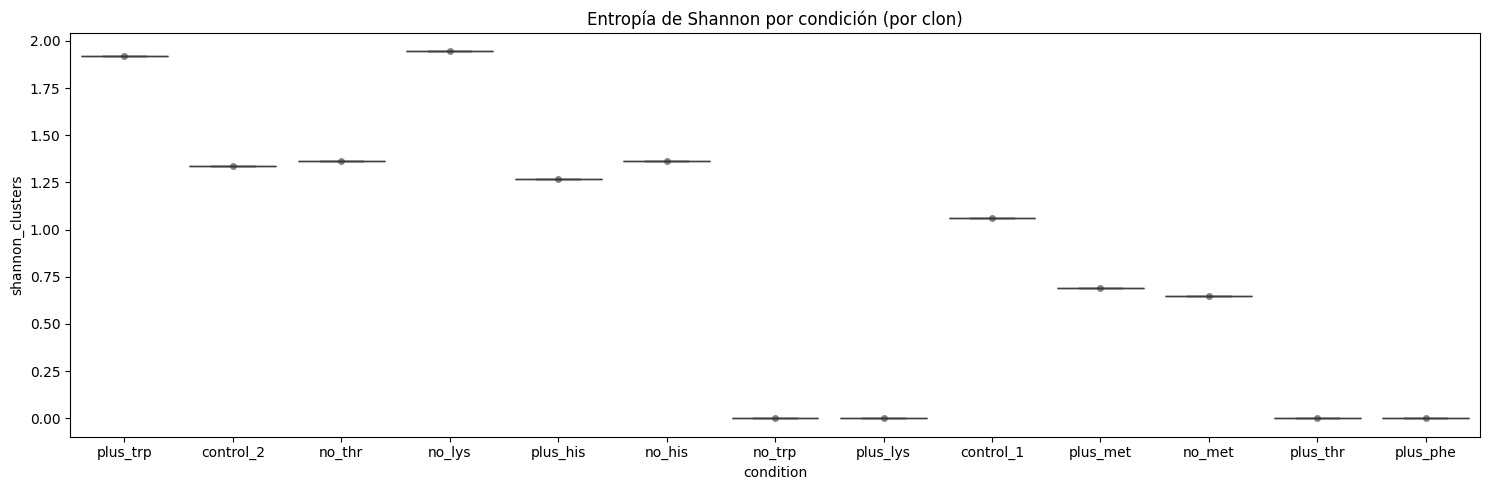

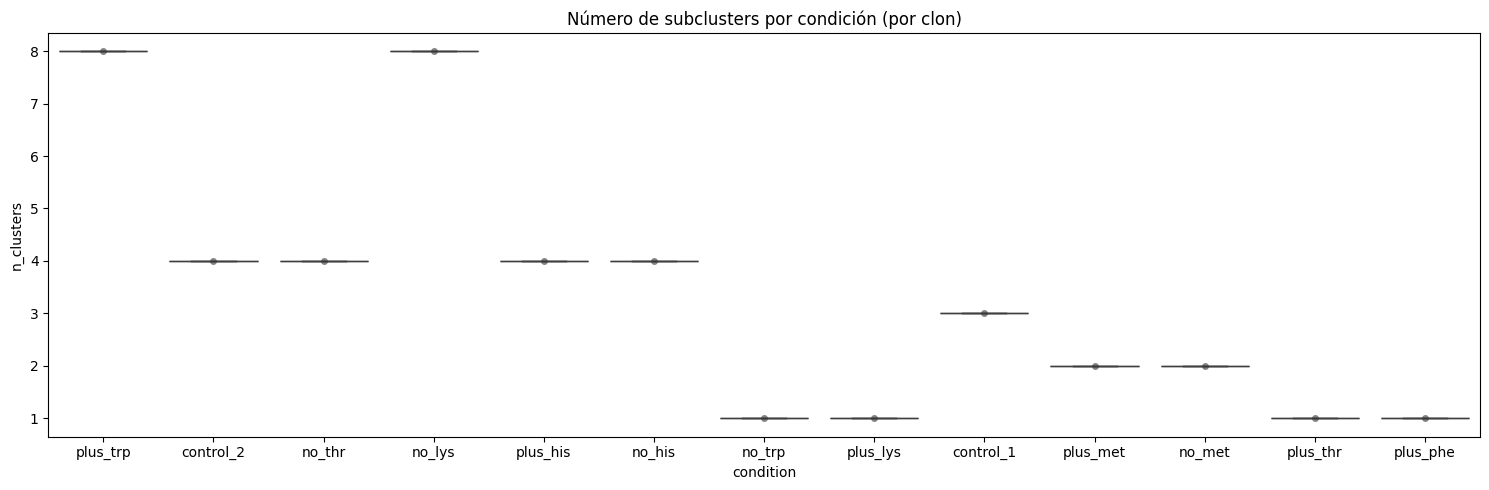

In [ ]:

df_metrics = pd.DataFrame(results)

print(df_metrics.columns)

plt.figure(figsize=(15,5))
sns.boxplot(data=df_metrics, x='condition', y='shannon_clusters')
sns.stripplot(data=df_metrics, x='condition', y='shannon_clusters',
              color='0.2', alpha=0.6)
plt.title('Entropía de Shannon por condición (por clon)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))
sns.boxplot(data=df_metrics, x='condition', y='n_clusters')
sns.stripplot(data=df_metrics, x='condition', y='n_clusters',
              color='0.2', alpha=0.6)
plt.title('Número de subclusters por condición (por clon)')
plt.tight_layout()
plt.show()


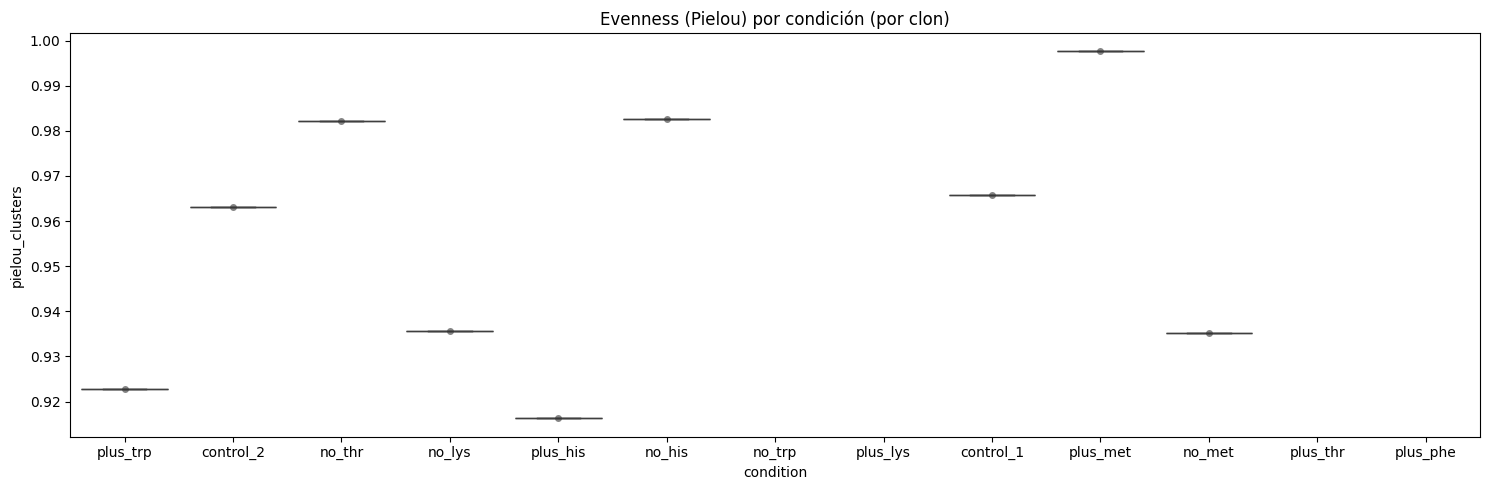

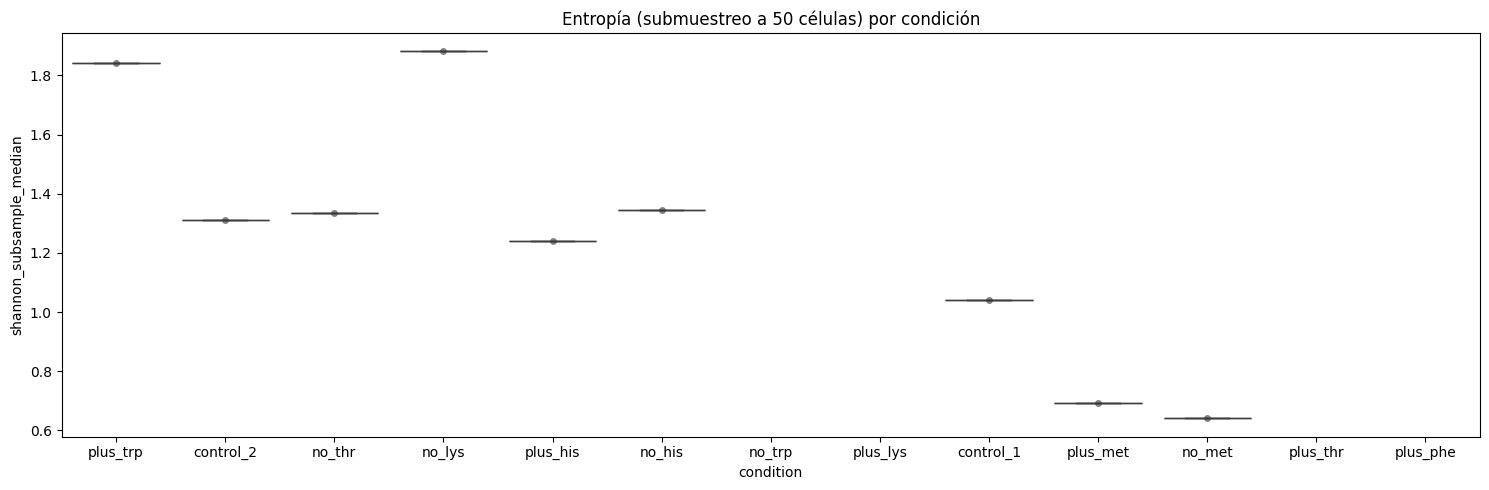

In [12]:
# Pielou's evenness
plt.figure(figsize=(15,5))
sns.boxplot(data=df_metrics, x='condition', y='pielou_clusters')
sns.stripplot(data=df_metrics, x='condition', y='pielou_clusters',
              color='0.2', alpha=0.6)
plt.title('Evenness (Pielou) por condición (por clon)')
plt.tight_layout()
plt.show()

# Entropía tras submuestreo
plt.figure(figsize=(15,5))
sns.boxplot(data=df_metrics, x='condition', y='shannon_subsample_median')
sns.stripplot(data=df_metrics, x='condition', y='shannon_subsample_median',
              color='0.2', alpha=0.6)
plt.title('Entropía (submuestreo a 50 células) por condición')
plt.tight_layout()
plt.show()


El **índice de evenness de Pielou** refleja cómo se distribuyen las células de un clon entre los subclusters detectados. Valores cercanos a 1 indican que los clones se distribuyen de manera equilibrada entre varios subclusters, lo que sugiere **mayor plasticidad celular**, mientras que valores cercanos a 0 indican que la mayoría de las células se concentran en uno o pocos subclusters, reflejando la **expansión de un estado concreto**. Al comparar entre condiciones, diferencias consistentes en los valores de Pielou sugieren que los clones ocupan una **gama más amplia o más restringida de estados celulares** dependiendo de la condición.  

La **entropía por condición**, que corresponde a la versión normalizada de Shannon, proporciona información similar sobre la diversidad intraclonal. Si los patrones observados se mantienen tras la normalización, esto indica que la entropía no se ve afectada por el ajuste, reforzando la validez de las comparaciones entre condiciones.

### Guardar archivo

En este bloque de código se guarda el dataframe con las métricas obtenidas en un archivo csv.

In [ ]:
df_metrics.to_csv("intra_clonal_diversity_mouse_3.csv", index=False)


-----
## Pool vs ratones

### Cargar archivos:

Al estar trabajando con tres muestras diferentes, se deben de cargar los datos sin normalizar, en este caso el objeto pickle obtenido tras ejecutar la libreta de *Preprocesado.ipynb*.

In [8]:
with open ("./pickles/counts_mouse_3_barcode_qcmetrics.pkl", 'rb') as f1 , \
    open ("./pickles/counts_mouse_1_barcode_qcmetrics.pkl", 'rb') as f2,\
    open ("./pickles/counts_pool_before_barcode_qc_metrics.pkl", 'rb') as f3:
    
    counts_mouse_3 = pickle.load(f1)
    counts_mouse_1 = pickle.load(f2)
    counts_pool = pickle.load(f3)

Al igual que al realizar el *merge* de los ratones, se añade una columna con el nombre de la muestra al que pertenece cada célula

In [ ]:
counts_mouse_1.obs["Sample"] = "Mouse_1"
counts_mouse_3.obs["Sample"] = "Mouse_3"
counts_pool.obs["Sample"] = "Pool_before"

adata = counts_mouse_1.concatenate(
    counts_mouse_3, counts_pool,
    batch_key="Sample",
    batch_categories=["Mouse_1", "Mouse_3", "Pool_before"]
)

C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_7100\4252056562.py:4: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = counts_mouse_1.concatenate(


In [32]:
adata.obs["Sample"].value_counts()

Sample
Mouse_3        16499
Pool_before     6046
Mouse_1         5195
Name: count, dtype: int64

### Normalización los datos

Una vez creado el objeto que contiene todas las muestras, se procede a realizar la normalización siguiendo el mismo procedimiento que en las otras notebooks.

In [33]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
adata = adata[:, adata.var['highly_variable']].copy()
# PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# Vecinos + UMAP (global)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata, min_dist=0.3)

c:\Python311\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


### Análisis de clones por condición

En esta sección se recorren todos los **clones únicos** y todas las **condiciones**, aplicando la función `analyze_clone_in_condition` a cada combinación clon-condición. Esta función calcula métricas de diversidad intraclonal incluyendo estimaciones de robustez mediante **bootstrap** y **submuestreo**. Los resultados de cada clon en cada condición se almacenan en una lista, generando un resumen completo que permite comparar la heterogeneidad intraclonal a lo largo de todas las condiciones del experimento.

In [34]:
adata.obs["barcode_mouse"] = adata.obs["Sample"].astype(str) + "_" + adata.obs["barcode"].astype(str)

clone_ids = adata.obs["barcode_mouse"].unique()
conditions = adata.obs["condition"].unique()

results = []
for clone in clone_ids:
    for cond in conditions:
        res = analyze_clone_in_condition(
            adata,
            clone_col="barcode_mouse",   
            clone_id=clone,
            condition=cond,
            cluster_resolution=0.5,
            subsample_size=50,
            n_bootstrap=200
        )
        results.append(res)

## Comparación entre muestras y condiciones
En este bloque se generan **visualizaciones comparativas** de las distintas métricas de diversidad y agrupamiento entre las condiciones experimentales. Para cada métrica analizada —**Shannon clusters**, **n clusters**, **dispersion UMAP**, **Pielou clusters** y **Simpson clusters**— se construyen **violin plots** que muestran la distribución de los valores por condición, superponiendo puntos individuales que representan cada muestra.

El uso de diferentes **colores y marcadores** permite distinguir de forma clara las muestras (**Pool_before**, **Mouse_1** y **Mouse_3**), facilitando la identificación de **patrones de variabilidad** y posibles diferencias entre grupos. Posteriormente, se eliminan los valores faltantes y se calcula la **mediana de las métricas principales por condición**, generando un **resumen cuantitativo** que complementa la interpretación visual y refuerza la comparación entre condiciones experimentales.

In [ ]:
df_metrics = pd.DataFrame(results)

df_metrics['Sample'] = df_metrics['clone'].str.split('_').str[:2].str.join('_')


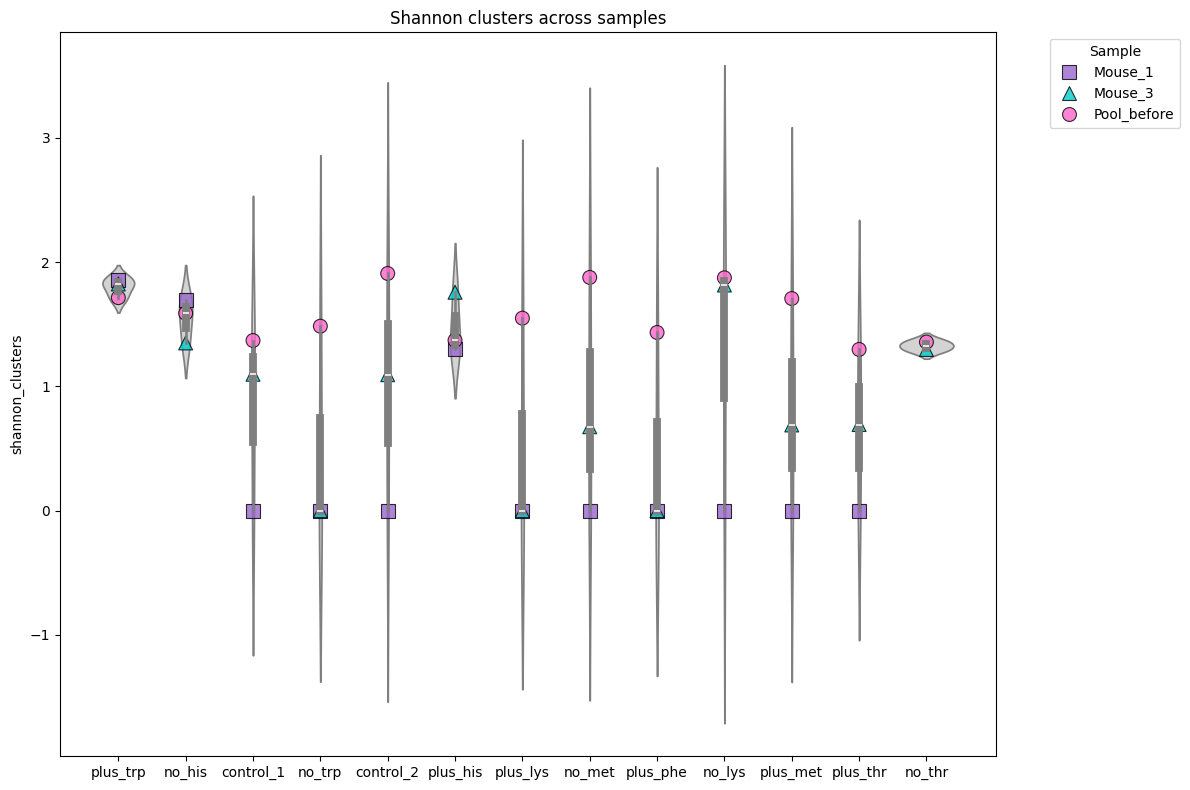

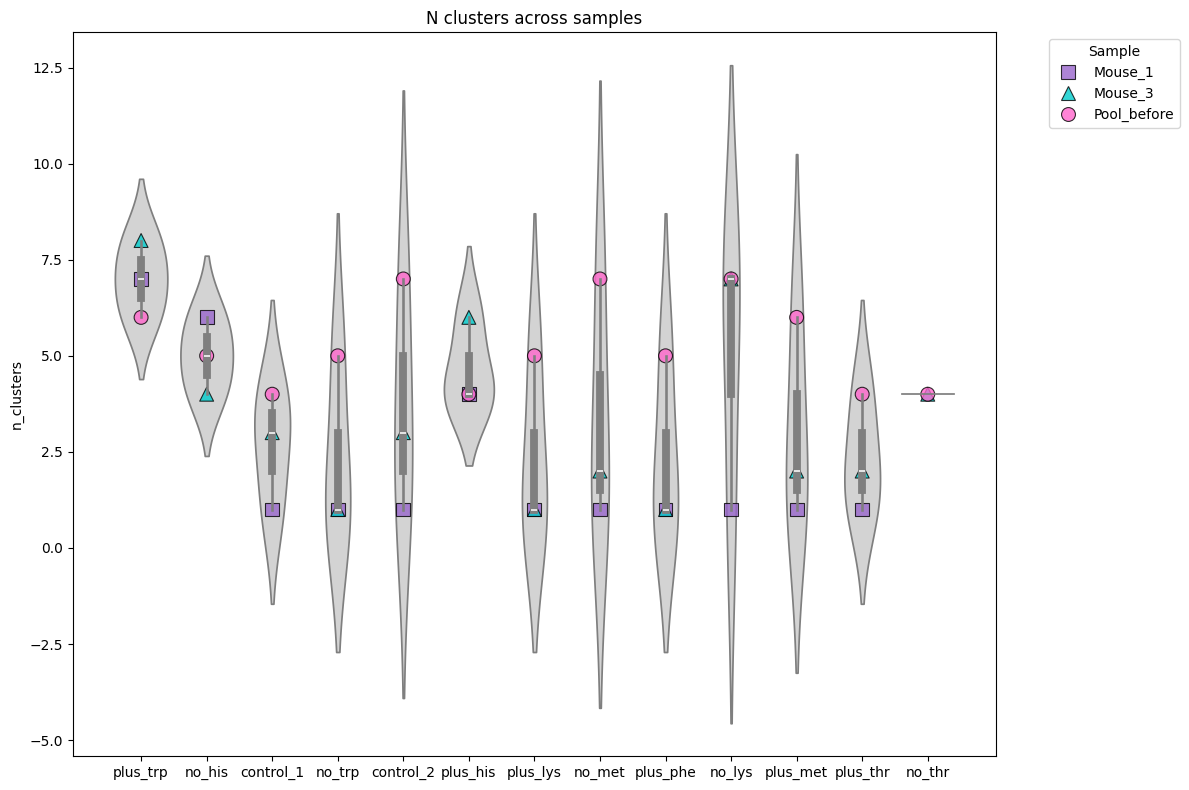

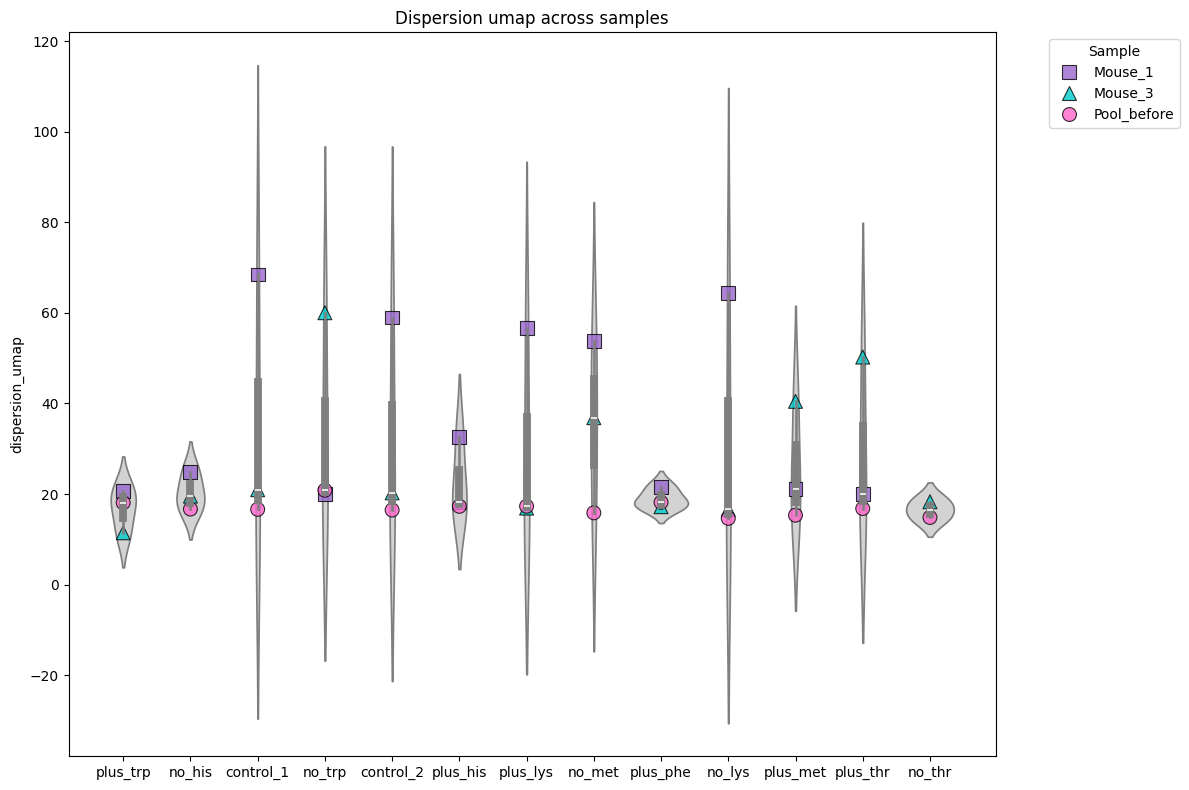

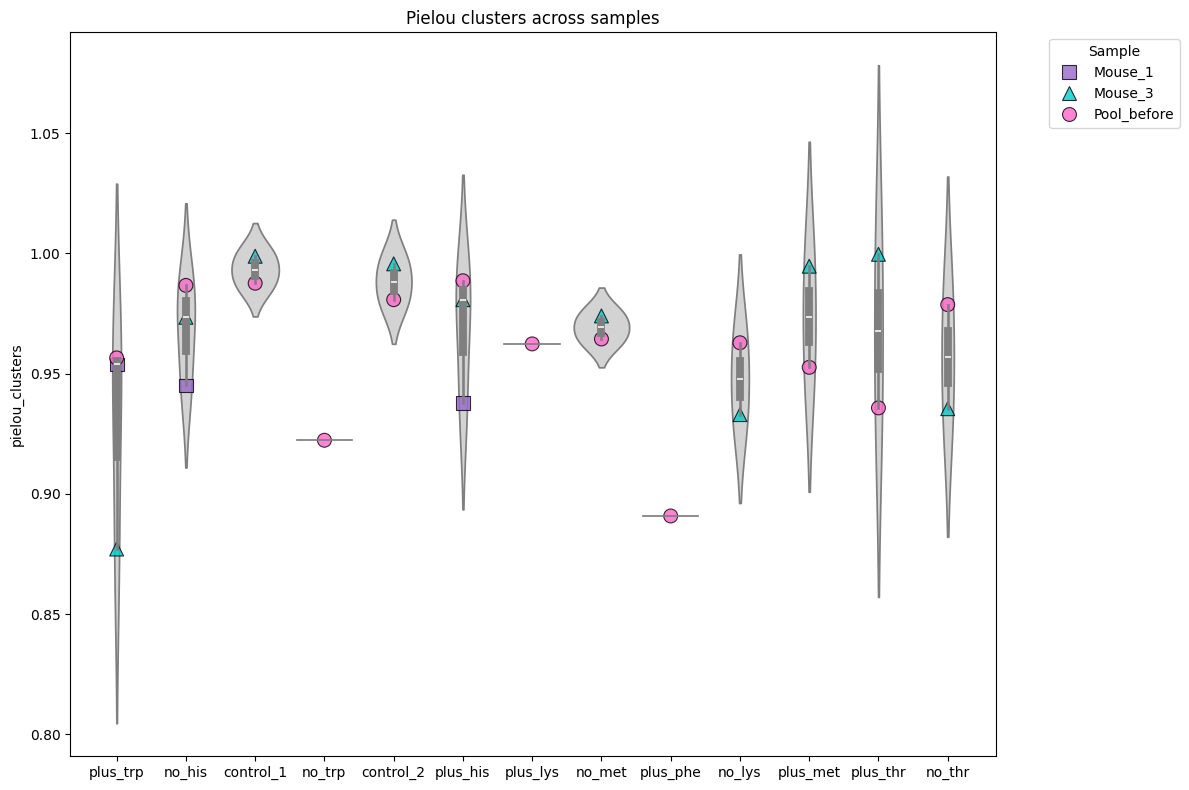

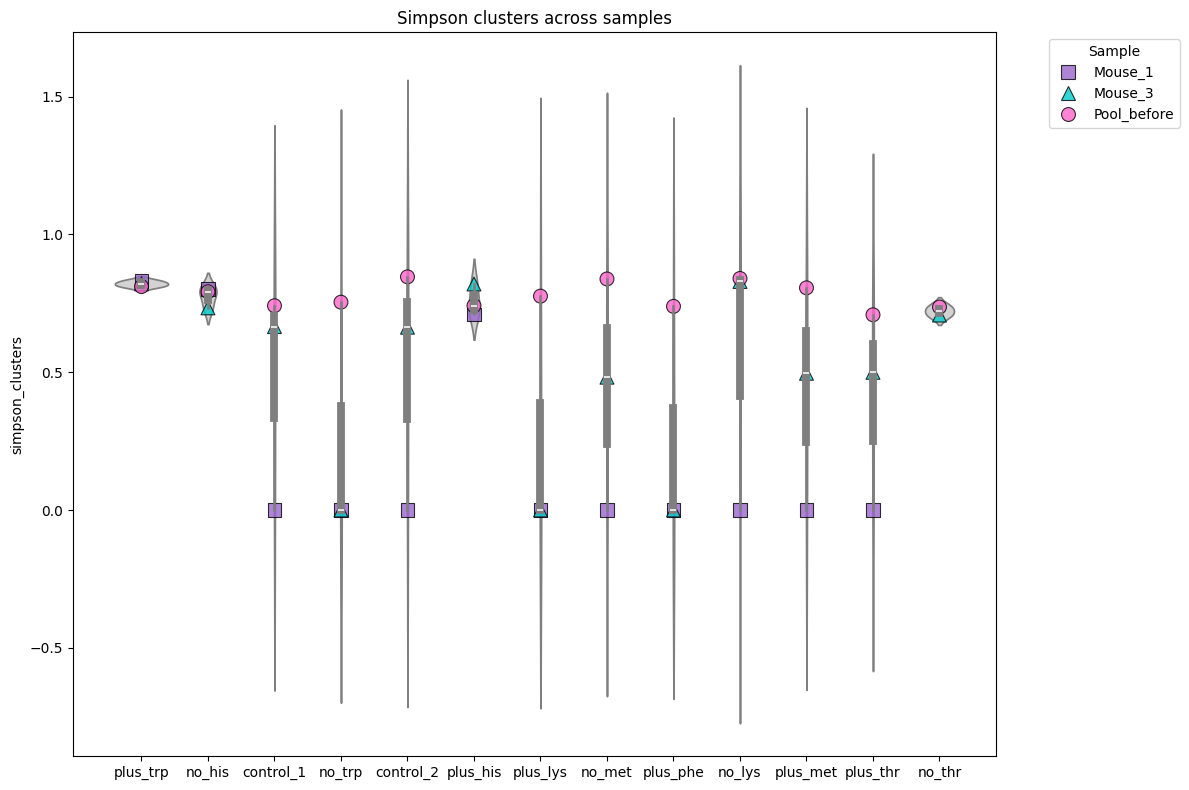

In [ ]:
metrics_to_plot = ["shannon_clusters", "n_clusters", "dispersion_umap",
                   "pielou_clusters", "simpson_clusters"] #Modificar dependiendo de las métricas que se quiera plotear

# Marcadores y colores por Sample
marker_dict = {"Pool_before": "o", "Mouse_1": "s", "Mouse_3": "^"}
palette = {"Pool_before": "#ff66cc", "Mouse_1": "#9966cc", "Mouse_3": "#00cccc"}

for metric in metrics_to_plot:
    plt.figure(figsize=(12,8))
    
    sns.violinplot(data=df_metrics, x="condition", y=metric, inner="box", color="lightgray")
    
    sns.scatterplot(
        data=df_metrics,
        x="condition",
        y=metric,
        hue="Sample",
        style="Sample",
        markers=marker_dict,
        palette=palette,
        s=100,
        edgecolor="black",
        alpha=0.8
    )
    
    plt.title(f"{metric.replace('_',' ').capitalize()} across samples")
    plt.xlabel("")
    plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



#### Generar archivo con métricas
En esta sección se filtran los resultados para conservar únicamente los valores válidos de las métricas principales (**entropía de Shannon**, **número de clusters** y **dispersión en UMAP**), eliminando aquellos registros con datos faltantes. Posteriormente, se calculan las **medianas** de estas métricas agrupando tanto por **condición experimental** como por **condición y muestra**. Este resumen estadístico permite obtener una visión global y comparativa de la **diversidad intraclonal** y la **heterogeneidad de las poblaciones celulares** en cada condición, facilitando la interpretación cuantitativa de los patrones observados en las visualizaciones previas.

In [21]:
df_valid = df_metrics.dropna(subset=["shannon_clusters","n_clusters","dispersion_umap"])

df_valid = df_metrics.dropna(subset=["shannon_clusters","n_clusters","dispersion_umap"])

summary = df_valid.groupby("condition")[["shannon_clusters","n_clusters","dispersion_umap"]].median()
print(summary)


           shannon_clusters  n_clusters  dispersion_umap
condition                                               
control_1          1.097334         3.0        20.960686
control_2          1.093872         3.0        20.282221
no_his             1.588060         5.0        19.549519
no_lys             1.815516         7.0        16.635893
no_met             0.675143         2.0        36.869217
no_thr             1.326796         4.0        16.578859
no_trp             0.000000         1.0        20.853901
plus_his           1.370552         4.0        18.180136
plus_lys           0.000000         1.0        17.317209
plus_met           0.689469         2.0        21.221605
plus_phe           0.000000         1.0        18.176441
plus_thr           0.692900         2.0        19.984642
plus_trp           1.823859         7.0        18.090286


In [ ]:
# Filtramos valores válidos
df_valid = df_metrics.dropna(subset=["shannon_clusters", "n_clusters", "dispersion_umap"])

# Resumen por condición (mediana)
summary_condition = df_valid.groupby("condition")[["shannon_clusters","n_clusters","dispersion_umap"]].median()

# Resumen por condición + Sample
summary_sample = df_valid.groupby(["condition","Sample"])[["shannon_clusters","n_clusters","dispersion_umap"]].median()

print("Resumen por condición:\n", summary_condition)
print("\nResumen por condición y sample:\n", summary_sample)




Resumen por condición:
            shannon_clusters  n_clusters  dispersion_umap
condition                                               
control_1          1.097334         3.0        20.960686
control_2          1.093872         3.0        20.282221
no_his             1.588060         5.0        19.549519
no_lys             1.815516         7.0        16.635893
no_met             0.675143         2.0        36.869217
no_thr             1.326796         4.0        16.578859
no_trp             0.000000         1.0        20.853901
plus_his           1.370552         4.0        18.180136
plus_lys           0.000000         1.0        17.317209
plus_met           0.689469         2.0        21.221605
plus_phe           0.000000         1.0        18.176441
plus_thr           0.692900         2.0        19.984642
plus_trp           1.823859         7.0        18.090286

Resumen por condición y sample:
                        shannon_clusters  n_clusters  dispersion_umap
condition Sample  

In [49]:
summary_sample.to_excel("diversidad_intra_clonal_muestra_condicion.xlsx", sheet_name="SummarySample")


En esta sección se realiza una comparación cuantitativa de las métricas de diversidad entre las muestras experimentales. Primero, se filtran los datos para conservar únicamente los **clones con un número suficiente de células** (≥5) y sin valores faltantes en las métricas principales: **entropía de Shannon**, **índice de Pielou** y **número de clusters**.  

A continuación, se calculan los **cambios relativos (deltas)** en estas métricas para cada clon, comparando las muestras **Mouse_1** y **Mouse_3** con la condición de referencia **Pool_before**. Finalmente, se aplica la prueba estadística de Mann–Whitney U para evaluar si las diferencias observadas entre los grupos son estadísticamente significativas. Este análisis permite detectar variaciones en la diversidad intraclonal y en la estructura de subpoblaciones entre las condiciones experimentales.

In [ ]:
df_valid = df_metrics.dropna(subset=["shannon_clusters", "pielou_clusters", "n_clusters", "n_cells"])
df_valid = df_valid[df_valid["n_cells"] >= 5]  # descartamos clones con pocas células


for metric in ["shannon_clusters", "pielou_clusters", "n_clusters"]:
    df_valid[f"delta_{metric}_Mouse_1"] = df_valid.groupby("clone")[metric].transform(
        lambda x: x - x[df_valid["Sample"]=="Pool_before"]
    )
    df_valid[f"delta_{metric}_Mouse_3"] = df_valid.groupby("clone")[metric].transform(
        lambda x: x - x[df_valid["Sample"]=="Pool_before"]
    )


for metric in ["shannon_clusters", "pielou_clusters", "n_clusters"]:
    for mouse in ["Mouse_1", "Mouse_3"]:
        mouse_vals = df_valid[df_valid["Sample"]==mouse][metric]
        pool_vals = df_valid[df_valid["Sample"]=="Pool_before"][metric]
        if len(mouse_vals) > 0 and len(pool_vals) > 0:
            stat, p = mannwhitneyu(mouse_vals, pool_vals, alternative='two-sided')
            print(f"{metric}: Pool vs {mouse} → p = {p:.4g}")


shannon_clusters: Pool vs Mouse_1 → p = 1
shannon_clusters: Pool vs Mouse_3 → p = 0.03775
pielou_clusters: Pool vs Mouse_1 → p = 0.2393
pielou_clusters: Pool vs Mouse_3 → p = 0.3364
n_clusters: Pool vs Mouse_1 → p = 0.728
n_clusters: Pool vs Mouse_3 → p = 0.08883
